### Code used for single cell data analysis and generation of anndata object  
<Add final title>
Yan Hu, Qianjiang Hu, et al. and Mareike Lehmann, Melanie Königshoff <correct author list>

In [1]:
## Load modules
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
import seaborn as sb
import scrublet as scr
import bbknn

import warnings
warnings.filterwarnings("ignore")

## Plotting Parameters
sc.set_figure_params(vector_friendly = True)
plt.rcParams["figure.figsize"] = (6, 5)
plt.rcParams.update({'font.size': 14})
sb.set_style("ticks")

def mysize(w, h, d):
    fig, ax = plt.subplots(figsize = (w, h), dpi = d)
    return(fig.gca())

## Set Filepaths
out_folder = "./COPD_Hu_2023/"
sc.logging.print_version_and_date()

2022-10-02 15:02:51.824234: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-02 15:02:51.824272: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Running Scanpy 1.7.1, on 2022-10-02 15:02.


In [2]:
from rpy2.robjects import pandas2ri
pandas2ri.activate()
%load_ext rpy2.ipython

In [3]:
%%R
suppressPackageStartupMessages(library(scran))
suppressPackageStartupMessages(library(SoupX)) 
suppressPackageStartupMessages(library(Matrix))

### Read in count matrices

In [4]:
samples = ["Koenigshoff_12072017", "Koenigshoff_02152019", "MKdonor55", "MKdonorLTC50", "Koenigshoff_12122018", 
           "Koenigshoff_COPDLTC37", "MKCOPDLTC39", "Koenigshoff_07182018", "MKCOPD79", "MKCOPD80"]

files = ["%s.h5" %s for s in samples]
grouping = pd.read_csv(out_folder + "denver_copd_samples.txt", sep = '\t', header = (0), index_col = 0)
grouping

,internal_id,smoke_status,health_status,age_status,age,gender
identifier,,,,,,
Koenigshoff_12072017,MK#2,non-smoker,healthy,old,56,male
Koenigshoff_02152019,LTC46,non-smoker,healthy,old,66,male
MKdonor55,LTC55,non-smoker,healthy,old,68,female
MKdonorLTC50,LTC50,non-smoker,healthy,old,66,male
Koenigshoff_12122018,LTC36,smoker,COPD,COPD,59,male
Koenigshoff_COPDLTC37,LTC37,smoker,COPD,COPD,66,male
MKCOPDLTC39,LTC39,smoker,COPD,COPD,68,female
Koenigshoff_07182018,LTC23,smoker,COPD,COPD,60,male
MKCOPD79,LTC79,Marijuana-smoker,COPD,COPD,58,male


In [5]:
def read_dges_10x(files):
    adatas = []
    
    for file in files:
        sample = file.replace(".h5", "")
        print("Reading DGE for sample %s" %(sample))
        a = sc.read_10x_h5(dge_path + file)
        a.var_names_make_unique()
        del(a.var)

        ## Add all columns from Grouping Table as Metainfo
        for col in grouping.columns:
            a.obs[col] = grouping.loc[sample, col]
            
        a.obs_names = ["%s_%s" %(grouping.loc[sample, "internal_id"],
                                 cell.replace("-1", "")) for cell in a.obs_names.values]
        adatas.append(a)
        
    return adatas

In [6]:
adatas = read_dges_10x(files)
adata = adatas[0].concatenate(adatas[1:], batch_key = "identifier", join = "outer", index_unique = None)  

## As outer join is used when concatenating the adatas, set NaN entries to zero
adata.X = np.nan_to_num(adata.X)
adata.X = adata.X.toarray()
adata

Reading DGE for sample Koenigshoff_12072017


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Reading DGE for sample Koenigshoff_02152019


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Reading DGE for sample MKdonor55


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Reading DGE for sample MKdonorLTC50


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Reading DGE for sample Koenigshoff_12122018


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Reading DGE for sample Koenigshoff_COPDLTC37


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Reading DGE for sample MKCOPDLTC39


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Reading DGE for sample Koenigshoff_07182018


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Reading DGE for sample MKCOPD79


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Reading DGE for sample MKCOPD80


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 89204 × 20975
    obs: 'age', 'age_status', 'gender', 'health_status', 'internal_id', 'smoke_status', 'identifier'

### Preprocessing and Quality Control

In [7]:
sc._utils.sanitize_anndata(adata)

## Calculate QC Metrics
adata.obs["n_counts"] = adata.X.sum(1)
adata.obs["n_genes"] = (adata.X > 0).sum(1)
mt_genes = [gene.startswith("MT-") for gene in adata.var_names]
adata.obs["percent_mito"] = adata.X[:, mt_genes].sum(1) / adata.obs["n_counts"]

... storing 'age_status' as categorical
... storing 'gender' as categorical
... storing 'health_status' as categorical
... storing 'internal_id' as categorical
... storing 'smoke_status' as categorical


In [8]:
## Summary Statistics before Filtering
info = pd.DataFrame(data = adata.obs.internal_id.cat.categories, columns = ["identifier"])
info["n_counts"] = adata.obs.groupby(["internal_id"])["n_counts"].median().values
info["n_genes"] = adata.obs.groupby(["internal_id"])["n_genes"].median().values
info["percent_mito"] = adata.obs.groupby(["internal_id"])["percent_mito"].mean().values
info["n_cells"] = adata.obs.groupby(["internal_id"])["n_genes"].size().values
info

,identifier,n_counts,n_genes,percent_mito,n_cells
0,LTC23,6288.0,1625.0,0.049506,5151
1,LTC36,5450.5,1694.0,0.072117,7998
2,LTC37,4824.0,1449.0,0.053448,11573
3,LTC39,6484.0,1581.0,0.044817,8913
4,LTC46,8646.0,2144.0,0.072677,12723
5,LTC50,8238.0,2026.0,0.067182,9943
6,LTC55,6988.0,1942.0,0.053421,9761
7,LTC79,5372.0,1396.5,0.047826,7402
8,LTC80,5467.0,1495.0,0.034316,8376
9,MK#2,11171.5,2495.0,0.089178,7364


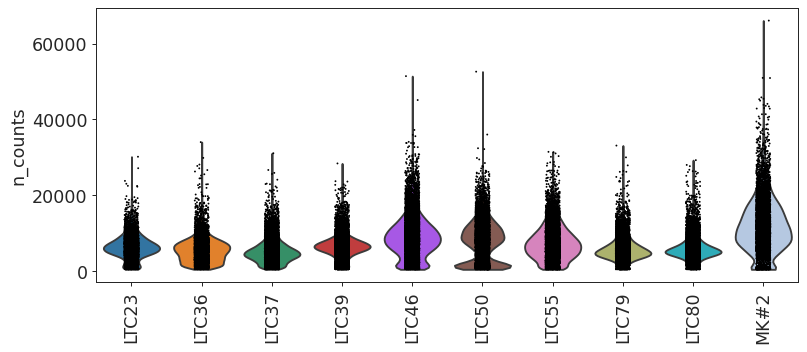

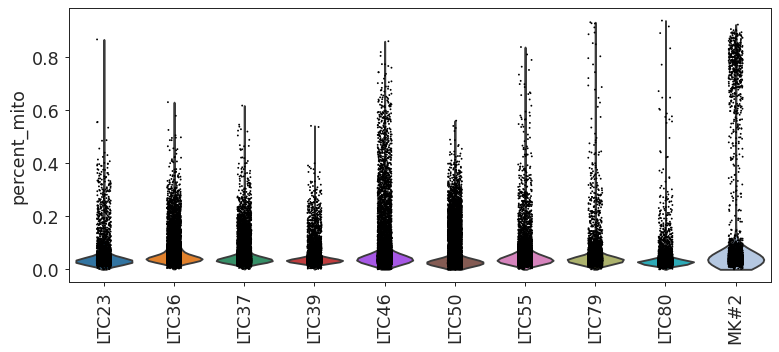

In [9]:
group = "internal_id"
sc.pl.violin(adata, "n_counts", groupby = group, size = 1.5, ax = mysize(10, 4, 90), rotation = 90)
sc.pl.violin(adata, "percent_mito", groupby = group, size = 1.5, ax = mysize(10, 4, 90), rotation = 90)

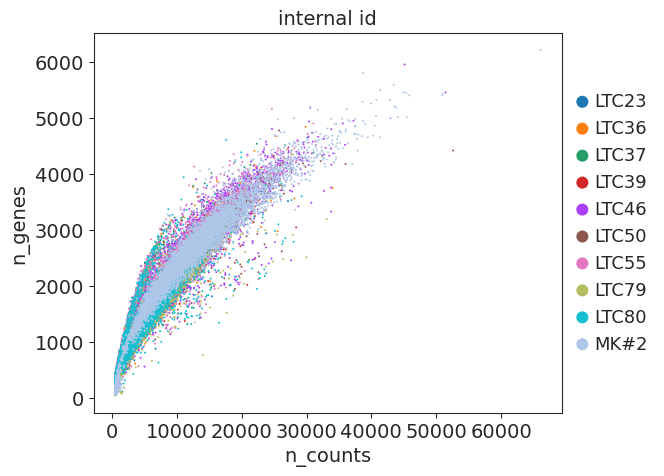

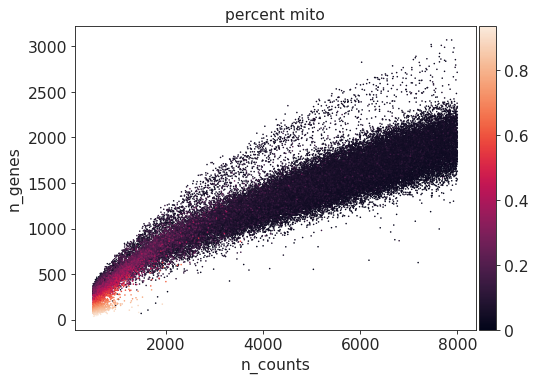

In [10]:
#Data quality summary plots
sc.pl.scatter(adata, "n_counts", "n_genes", color = group, ax = mysize(6, 5, 100), size = 8)

## Zoom in to range
sc.pl.scatter(adata[adata.obs["n_counts"] < 8000],"n_counts","n_genes", color = "percent_mito", size = 8)

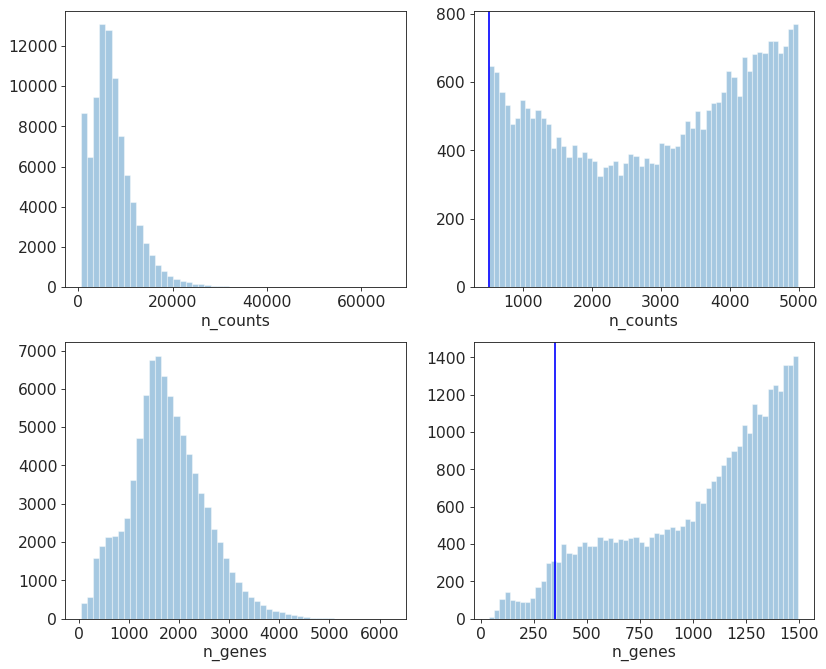

In [11]:
## Thresholding decision: counts
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 10))
axs = axs.ravel()

sb.distplot(adata.obs['n_counts'], kde = False, ax = axs[0])
sb.distplot(adata.obs['n_counts'][adata.obs['n_counts'] < 5000], kde = False, bins = 60, ax = axs[1])
sb.distplot(adata.obs['n_genes'], kde = False, ax = axs[2])
sb.distplot(adata.obs['n_genes'][adata.obs['n_genes'] < 1500], kde = False, bins = 60, ax = axs[3])

axs[1].axvline(500, color = "blue")
axs[3].axvline(350, color = "blue")
plt.show()

### Sample specific thresholds

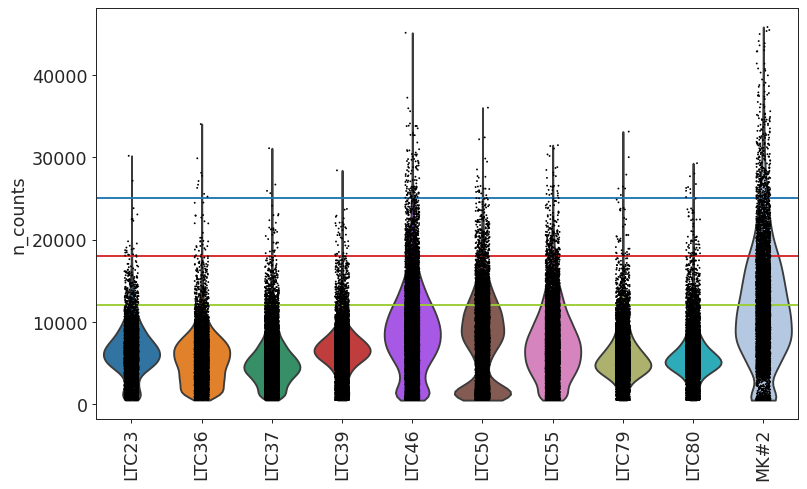

In [12]:
sc.pl.violin(adata[adata.obs.n_counts < 50000], "n_counts", groupby = group, 
             ax = mysize(10, 6, 90), rotation = 90, size = 1.5, show = False)

## To highlight cutoffs
plt.axhline(25000, color = "tab:blue")     ## high
plt.axhline(18000, color = "tab:red")      ## medium
plt.axhline(12000, color = "yellowgreen")  ## low
plt.show()

In [13]:
groups = {"LTC23": "low", "LTC36": "medium", "LTC37": "medium", "LTC39": "low", "LTC46": "high", 
          "LTC50": "medium", "LTC55": "medium", "LTC79": "low", "LTC80": "low", "MK#2": "high"}
adata.obs["QC_group"] = [groups[c] if c in groups.keys() else "high" for c in adata.obs.internal_id]

sc._utils.sanitize_anndata(adata)
adata.obs.QC_group.value_counts()

... storing 'QC_group' as categorical


medium    39275
low       29842
high      20087
Name: QC_group, dtype: int64

In [14]:
## Specify group-specific thresholds and do the filtering
thresh = {"low": 12000, "medium": 18000, "high": 25000}

passed_cells = [c for c, g in zip(adata.obs_names, adata.obs.QC_group) if adata.obs.n_counts[c] < thresh[g]]
print(len(passed_cells))
adata._inplace_subset_obs(passed_cells)

86752


### Actually do the Filtering for remaining QC Parameters

In [15]:
print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_genes = 350)
print('Number of cells after min count filter: {:d}'.format(adata.n_obs))

sc.pp.filter_genes(adata, min_cells = 3)
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))

adata = adata[adata.obs["percent_mito"] < 0.2]            ## have 0.15 in current object
print('Number of cells after MT filter: {:d}'.format(adata.n_obs))

Total number of cells: 86752
Number of cells after min count filter: 85044
Number of cells after gene filter: 85044
Number of cells after MT filter: 82385


### Plots after Filtering

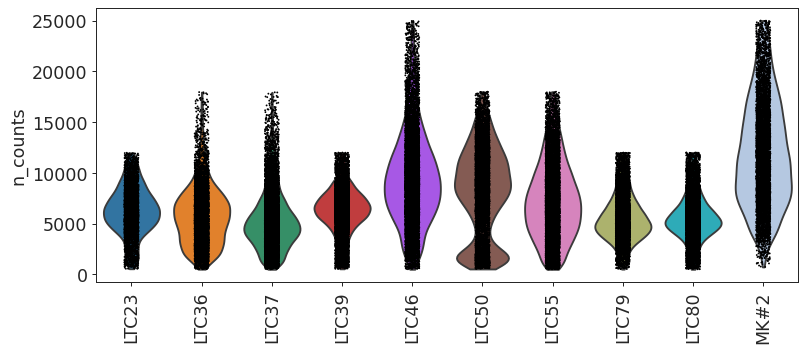

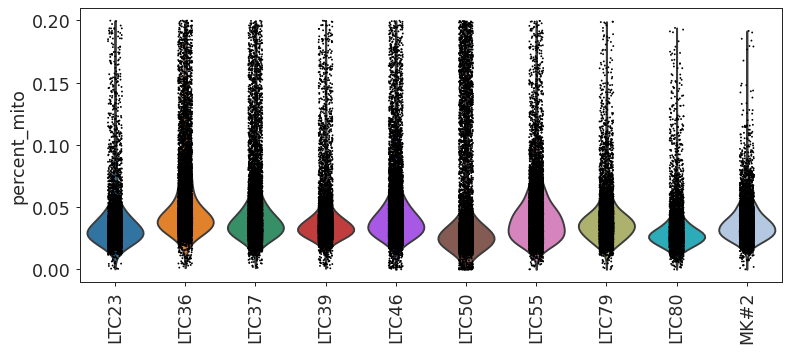

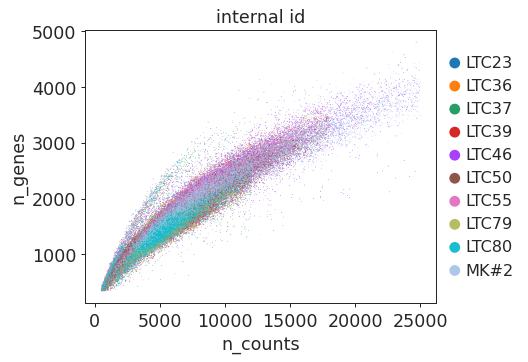

In [16]:
sc.pl.violin(adata, "n_counts", groupby = group, size = 1.5, ax = mysize(10, 4, 90), rotation = 90)
sc.pl.violin(adata, "percent_mito", groupby = group, size = 1.5, ax = mysize(10, 4, 90), rotation = 90)
sc.pl.scatter(adata, "n_counts", "n_genes", color = group, ax = mysize(5, 4, 90))

### Doublet Detection with Scrublet (sample-wise)

In [17]:
ids = adata.obs.internal_id.cat.categories
adata.obs["doublet_scores"] = np.nan

for i, cur_id in enumerate(ids):
    sub = adata[adata.obs.internal_id == cur_id].copy()

    ## Input: raw (unnormalized) UMI counts matrix counts_matrix with cells as rows and genes as columns
    print("%s\tCalculating doublet score for %s" %(i, cur_id))
    scrub = scr.Scrublet(sub.X)
    doublet_scores, predicted_doublets = scrub.scrub_doublets(verbose = False)
    doublet_scores = pd.DataFrame(doublet_scores, index = sub.obs_names, columns = ["doublet_scores"])
    adata.obs["doublet_scores"].update(doublet_scores.doublet_scores)
    

Trying to set attribute `.obs` of view, copying.


0	Calculating doublet score for LTC23
1	Calculating doublet score for LTC36
2	Calculating doublet score for LTC37
3	Calculating doublet score for LTC39
4	Calculating doublet score for LTC46
5	Calculating doublet score for LTC50
6	Calculating doublet score for LTC55
7	Calculating doublet score for LTC79
8	Calculating doublet score for LTC80
9	Calculating doublet score for MK#2


### Ambient gene removal with SoupX and normalization with Scran

In [18]:
%%R
## Define the Functions beforehand

soup_counts <- function(data, cells, genes, soupx_groups){
    print(dim(data))
    rownames(data) = genes
    colnames(data) = cells
    data <- as(data, "sparseMatrix")
    
    ## Generate SoupChannel Object for SoupX 
    sc = SoupChannel(data, data, calcSoupProfile = FALSE)
    soupProf = data.frame(row.names = rownames(data), est = rowSums(data)/sum(data), counts = rowSums(data))
    sc = setSoupProfile(sc, soupProf)
    sc = setClusters(sc, soupx_groups)

    ## Set the Contamination Fraction manually 
    print("Started SoupX")
    sc = setContaminationFraction(sc, 0.3)
    out = adjustCounts(sc, roundToInt = TRUE)
    return(out)
}

get_size_factors <- function(out, scran_groups){
    ## Input souped count matrix directly to Scran
    print("Started Size Factor Calculation")
    size_factors = computeSumFactors(out, clusters = scran_groups, min.mean = 0.1)
    
    return(size_factors)
}

In [19]:
#Perform a clustering for SoupX and scran normalization in clusters
adata_pp = adata.copy()
sc.pp.normalize_per_cell(adata_pp, counts_per_cell_after = 1e6)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps = 15)
sc.pp.neighbors(adata_pp)
sc.tl.louvain(adata_pp, key_added = "soupx_groups", resolution = 2)
sc.tl.louvain(adata_pp, key_added = "scran_groups", resolution = 1)

#Preprocess variables for SoupX and scran normalization
soupx_groups = adata_pp.obs["soupx_groups"]
scran_groups = adata_pp.obs["scran_groups"] 

cells = adata.obs_names
genes = adata.var_names
#data = adata.X.T.todense()

In [21]:
%R -i data -i cells -i genes -i soupx_groups out <- soup_counts(data, cells, genes, soupx_groups)
%R -i scran_groups -o size_factors size_factors <- get_size_factors(out, scran_groups)
%R -o data data <- t(as.matrix(out))

[1] Started SoupX
[1] Started Size Factor Calculation


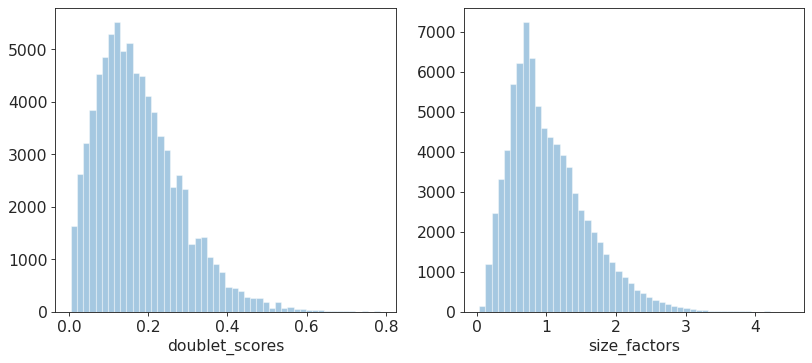

In [24]:
## Add results to adata
adata.obs["size_factors"] = np.nan
adata.obs["size_factors"].update(size_factors.size_factors)

## Add ambient expression corrected count layer
from scipy import sparse
adata.layers["unsouped_counts"] = adata.X.copy()
adata.layers["counts"] = sparse.csr_matrix(data.copy())
adata.X = sparse.csr_matrix(data.copy())

fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))
axs = axs.ravel()
sb.distplot(adata.obs["doublet_scores"], kde = False, ax = axs[0])
sb.distplot(adata.obs["size_factors"], kde = False, ax = axs[1])
plt.show()

### Normalize adata and Log Transform

In [25]:
adata.X /= adata.obs['size_factors'].values[:, None]
sc.pp.log1p(adata)
adata.X = sparse.csr_matrix(adata.X)

In [26]:
del(data)
del(adata_pp)

print("ambient-corrected counts\n", type(adata.layers["counts"]), "\n", 
      adata.layers["counts"][40000:40010,110:120].todense())
print("log-normed Counts in X\n", type(adata.X), "\n",  adata.X[40000:40010, 110:120].todense())

ambient-corrected counts
 <class 'scipy.sparse.csr.csr_matrix'> 
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
log-normed Counts in X
 <class 'scipy.sparse.csr.csr_matrix'> 
 [[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.56906616 0.56906616]
 [0.         0.         0.         0.         0.73845497 0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.

### Selection of highly Variable Genes (consider in how many Samples they are variable)

... storing 'patient_ID' as categorical
... storing 'health_state' as categorical
... storing 'cell_type' as categorical


<AxesSubplot:>

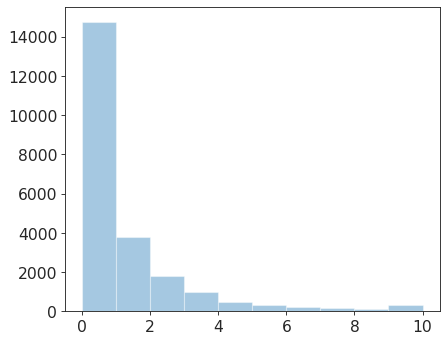

In [27]:
batch = "patient_ID"
sc.pp.highly_variable_genes(adata, min_disp = None, max_disp = None, min_mean = None, max_mean = None, 
                                batch_key = batch, n_top_genes = 2000, n_bins = 20, flavor = "cell_ranger", 
                                subset = False)
vartab = pd.DataFrame(adata.var["highly_variable_nbatches"], index = adata.var_names)
sb.distplot(vartab, kde = False, bins = len(np.unique(adata.obs[batch])))

In [28]:
## Original selection
# hvgs = vartab[vartab.highly_variable_nbatches.values >= 5].index
## Remove cell cycle genes from list 
# cc_genes = [x.strip() for x in open("regev_lab_cell_cycle_genes.txt")]
# hvgs = np.setdiff1d(hvgs, cc_genes)

## Set it based on exported list to stay consistent
hvgs = pd.read_csv(out_folder + "EpithelCOPD_variable_genes.txt", header = None).iloc[:, 0].values
adata.var["highly_variable"] = [g in hvgs for g in adata.var_names]
sum(adata.var["highly_variable"])

599

### Visualizations

... storing 'patient_ID' as categorical
... storing 'health_state' as categorical
... storing 'cell_type' as categorical


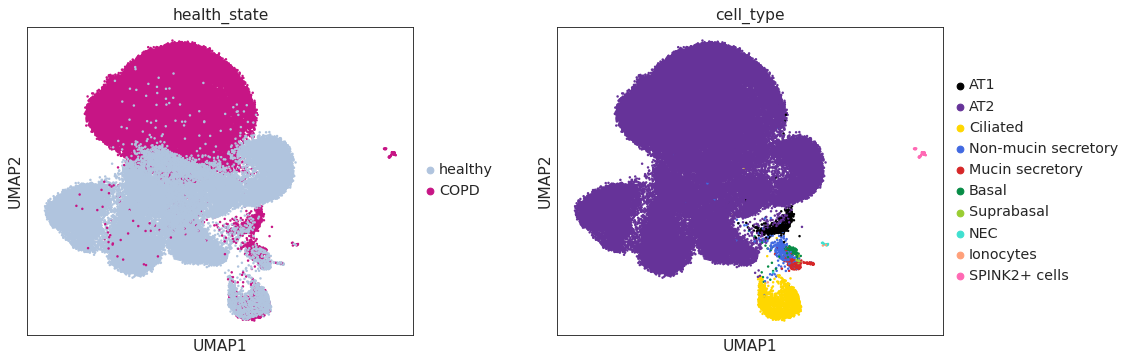

In [30]:
## Original Parameters for dimensionality reduction
# sc.pp.pca(adata, n_comps = 50, use_highly_variable = True)
# bbknn.bbknn(adata, neighbors_within_batch = 30, n_pcs = 50, batch_key = "patient_ID")
# sc.tl.umap(adata)

## Set UMAP coordinates based on coordinates to be consistend with figures
meta = pd.read_csv(out_folder + "EpithelCOPD_cells_metadata.txt", sep = "\t", index_col = 0)
adata.obsm["X_umap"] = meta.loc[:, ["umap_1", "umap_2"]].values

## Add annotation from metadata file
adata.obs = meta.iloc[:, :-2]
sc._utils.sanitize_anndata(adata)

## Set colours
adata.obs.cell_type.cat.reorder_categories(['AT1', 'AT2', 'Ciliated', 'Non-mucin secretory', 'Mucin secretory',
                        'Basal', 'Suprabasal', 'NEC', 'Ionocytes', 'SPINK2+ cells'], inplace = True)
adata.uns["cell_type_colors"] = ['black', 'rebeccapurple', 'gold', 'royalblue', 'tab:red','#078c46',
                                 'yellowgreen', 'turquoise', 'lightsalmon', 'hotpink']

adata.obs.health_state.cat.reorder_categories(["healthy", "COPD"], inplace = True)
adata.uns["health_state_colors"] = ['lightsteelblue', "mediumvioletred"]

sc.pl.umap(adata, color = ["health_state", "cell_type"], size = 20, wspace = 0.25)

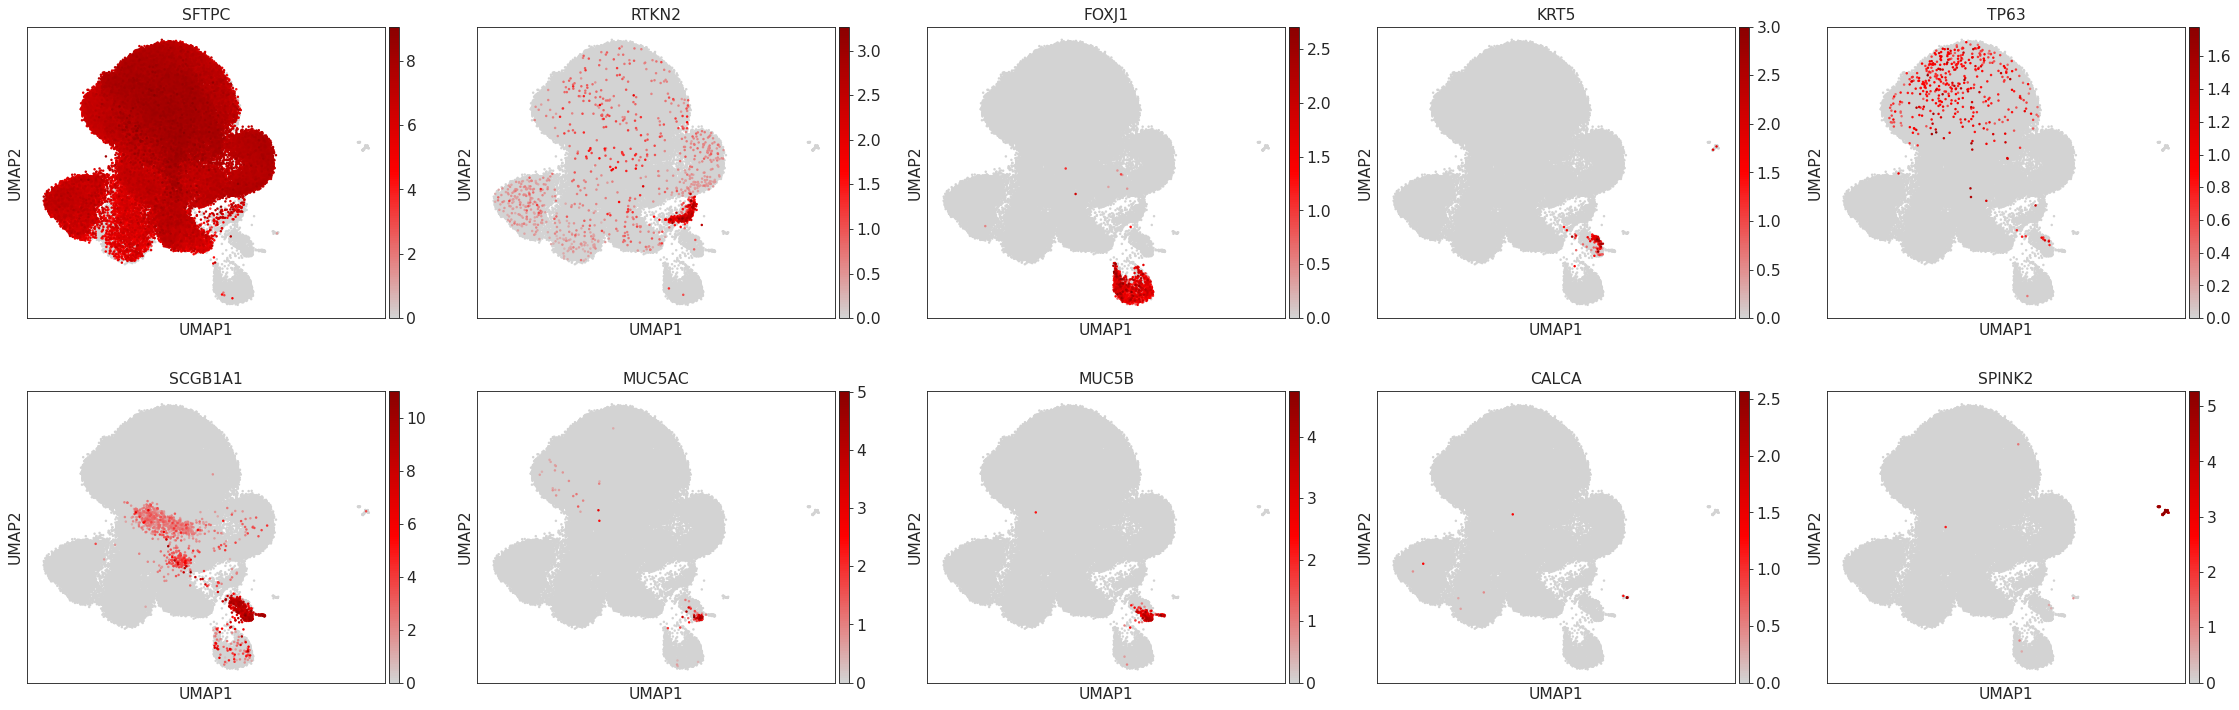

In [31]:
from matplotlib import colors
gray_red = colors.LinearSegmentedColormap.from_list("grouping", ["lightgray", "red", "darkred"], N = 128)

marker_genes = ["SFTPC", "RTKN2", "FOXJ1", "KRT5", "TP63", "SCGB1A1", "MUC5AC", "MUC5B", "CALCA", "SPINK2"]
sc.pl.umap(adata, color = marker_genes, cmap = gray_red, size = 20, ncols = 5)

### Save the adata object

In [32]:
adata.write(out_folder + "EpithelCOPD_annotated.h5ad")